In [8]:
import string
import re

# 以下の記号はスペースに置き換えます（カンマ、ピリオドを除く）。
# punctuationとは日本語で句点という意味です
print("区切り文字：", string.punctuation)
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# 前処理


def preprocessing_text(text):
    # 改行コードを消去
    text = re.sub('<br />', '', text)

    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ","):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）


def tokenizer_punctuation(text):
    return text.strip().split()


# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret


# 動作を確認します
print(tokenizer_with_preprocessing('I like cats.'))

区切り文字： !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['I', 'like', 'cats', '.']


In [9]:
import torchtext

max_length = 142
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing, 
                            use_vocab=True, 
                            lower=True, include_lengths=True, batch_first=True,
                            fix_length=max_length, init_token='<cls>',
                            eos_token='<eos>')

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(
    path='drive/My Drive/dataset/TEC/train_test/', train='train.csv', 
    validation='val.csv', test='test.csv', format='csv', fields=[('text', TEXT), ('Label', LABEL)]
)

#分かち書きや正規化などが終了している
print(len(train_ds))
print(vars(train_ds[0]))

17050
{'text': ['great', 'start', 'to', 'the', 'day', 'because', 'of', 'an', 'awesome', 'brother', 'and', 'a', 'great', 'god', 'thankful', 'gobblegobble'], 'Label': '3'}


In [11]:
from torchtext.vocab import Vectors

english_fasttext_vectors = Vectors(name='drive/My Drive/wiki-news-300d-1M.vec')

print(english_fasttext_vectors.dim)
print(len(english_fasttext_vectors.itos))

100%|█████████▉| 999608/999994 [02:10<00:00, 7461.55it/s]

300
999994


In [15]:
#ボキャブラリを作成、最低でも10回以上出現している単語
TEXT.build_vocab(train_ds, vectors=english_fasttext_vectors, min_freq=2)
print(TEXT.vocab.vectors.shape)

torch.Size([9878, 300])


In [16]:
train_dl = torchtext.data.Iterator(train_ds, batch_size=64, train=True)
val_dl = torchtext.data.Iterator(val_ds, batch_size=64, train=False, sort=False)
test_val = torchtext.data.Iterator(test_ds, batch_size=64, train=False, sort=False)

batch = next(iter(val_dl))
print(batch.text)
print(batch.Label)

(tensor([[   2,    5,  113,  ...,    1,    1,    1],
        [   2,  630, 4808,  ...,    1,    1,    1],
        [   2,    6, 1746,  ...,    1,    1,    1],
        ...,
        [   2,    5,  227,  ...,    1,    1,    1],
        [   2,  186,  185,  ...,    1,    1,    1],
        [   2,  752,   32,  ...,    1,    1,    1]]), tensor([23,  9, 12, 34, 32, 18, 21, 19, 25, 11, 11, 26, 26, 26, 19, 18, 13,  5,
        29, 16, 10, 27, 14, 27, 21, 26, 22, 22, 23, 11, 25, 12, 19, 26, 19, 21,
        13, 11, 30, 13, 21, 32, 16, 19, 29, 29, 19, 14, 16, 23, 24, 15, 20, 25,
        26, 21, 23, 24, 18,  8, 10, 28, 19, 22]))
tensor([3, 1, 1, 5, 5, 4, 3, 0, 3, 3, 3, 5, 4, 3, 4, 3, 3, 3, 5, 3, 0, 1, 5, 4,
        3, 3, 5, 4, 5, 4, 4, 4, 4, 5, 1, 1, 3, 3, 4, 5, 2, 1, 3, 5, 3, 3, 5, 5,
        3, 3, 3, 3, 0, 4, 4, 3, 5, 3, 3, 3, 1, 4, 1, 3])


In [0]:
# パッケージのimport
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
#埋め込み層の定義

class Embedder(nn.Module):
  def __init__(self, text_embedding_vectors):
    super(Embedder, self).__init__()
    #freezeで更新をしない
    self.embeddings=nn.Embedding.from_pretrained(
        embeddings=text_embedding_vectors, freeze=True)

  def forward(self, x):
    x_vec = self.embeddings(x)

    return x_vec

import math
class PositionalEncoder(nn.Module):
    '''入力された単語の位置を示すベクトル情報を付加する'''

    def __init__(self, d_model=300, max_seq_len=256):
        super().__init__()

        self.d_model = d_model  # 単語ベクトルの次元数

        # 単語の順番（pos）と埋め込みベクトルの次元の位置（i）によって一意に定まる値の表をpeとして作成
        pe = torch.zeros(max_seq_len, d_model)

        # GPUが使える場合はGPUへ送る、実際に学習時には使用する
        #学習時以外(動作確認)で使うとerrorでるっぽい？
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        pe = pe.to(device)

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos /
                                          (10000 ** ((2 * (i + 1))/d_model)))

        # 表peの先頭に、ミニバッチ次元となる次元を足す
        self.pe = pe.unsqueeze(0)

        # 勾配を計算しないようにする
        self.pe.requires_grad = False

    def forward(self, x):

        # 入力xとPositonal Encodingを足し算する
        # xがpeよりも小さいので、大きくする
        ret = math.sqrt(self.d_model)*x + self.pe
        return ret
    
class Attention(nn.Module):
  def __init__(self, d_model=300):
    super().__init__()

    #query, value, keyを出力
    self.q_linear = nn.Linear(d_model, d_model)
    self.v_linear = nn.Linear(d_model, d_model)
    self.k_linear = nn.Linear(d_model, d_model)

    #ここは最後のoutput
    self.out = nn.Linear(d_model, d_model)

    self.d_k = d_model

  def forward(self, q, k, v, mask):
    #query, value, keyを出力
    k = self.k_linear(k)
    q = self.q_linear(q)
    v = self.v_linear(v)

    #queryに対するmemoryの関連度を計算している, 大きさの制限もかけている
    weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

    mask = mask.unsqueeze(1)
    #mask部分を-infで置き換え
    weights = weights.masked_fill(mask==0, -1e9)

    """
    softmaxで関連度を正規化
    ここはshapeが(queryの単語数,　memoryの単語数)になっており
    各行はqueryに対して各memoryの関連度(のようなもの)を表している
    これを関数から出力することで可視化に使っている。
    """
    normlized_weights = F.softmax(weights, dim=-1)

    #Attention
    output = torch.matmul(normlized_weights, v)
    output = self.out(output)

    return output, normlized_weights
  
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()

        # LayerNormalization層
        # https://pytorch.org/docs/stable/nn.html?highlight=layernorm
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        # Attention層
        self.attn = Attention(d_model)

        # Attentionのあとの全結合層2つ
        self.ff = FeedForward(d_model)

        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # 正規化とAttention
        x_normlized = self.norm_1(x)
        output, normlized_weights = self.attn(
            x_normlized, x_normlized, x_normlized, mask)
        
        x2 = x + self.dropout_1(output)

        # 正規化と全結合層
        x_normlized2 = self.norm_2(x2)
        output = x2 + self.dropout_2(self.ff(x_normlized2))

        return output, normlized_weights
  
class ClassificationHead(nn.Module):
  def __init__(self, d_model=300, output_dim=5):
    super().__init__()

    self.linear = nn.Linear(d_model, output_dim)
    
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  def forward(self, x):
    #各バッチの<cls>の特徴量を抽出する
    x0 = x[:, 0, :]
    out = self.linear(x0)

    return out

class TransformerClassification(nn.Module):
  def __init__(self, text_embedding_vectors, d_model=300, max_seq_len=140,
               output_dim=5):
    super().__init__()

    self.net1 = Embedder(text_embedding_vectors)
    self.net2 = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
    self.net3_1 = TransformerBlock(d_model=d_model)
    self.net3_2 = TransformerBlock(d_model=d_model)
    self.net4 = ClassificationHead(output_dim=output_dim, d_model=d_model)

  def forward(self, x, mask):
    x1 = self.net1(x)
    x2 = self.net2(x1)
    x3_1, normlized_weights_1 = self.net3_1(x2, mask)
    x3_2, normlized_weights_2 = self.net3_2(x3_1, mask)
    x4 = self.net4(x3_2,)
    return x4, normlized_weights_1, normlized_weights_2

In [19]:
# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dl, "val": val_dl}
# モデル構築
net = TransformerClassification(
    text_embedding_vectors=TEXT.vocab.vectors, d_model=300, max_seq_len=142, output_dim=6)

# ネットワークの初期化を定義


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner層の初期化
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)


# 訓練モードに設定
net.train()

# TransformerBlockモジュールを初期化実行
net.net3_1.apply(weights_init)
net.net3_2.apply(weights_init)


print('ネットワーク設定完了')

ネットワーク設定完了


In [0]:
#損失関数を定義
criterion = nn.CrossEntropyLoss()

#最適化手法
learning_rate = 2e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [0]:
#モデルを訓練して、訓練したモデルをreturnする
#モデル、辞書型で定義したdataloder(イテレータ)、損失関数、オプティマイザ、エポック数を渡す
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    # モデルをGPUへ渡す
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 各epoch
    for epoch in range(num_epochs):
        # 学習と検証
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 各バッチ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書オブジェクト

                # GPUが使えるならGPUにデータを送る
                inputs = batch.text[0].to(device)  # 文章
                labels = batch.Label.to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # mask作成
                    input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
                    input_mask = (inputs != input_pad) #mask部分がFalseに

                    # モデルに入力
                    outputs, _, _ = net(inputs, input_mask)
                    loss = criterion(outputs, labels)  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        #勾配を計算
                        loss.backward()
                        #パラメータの更新
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))

    return net

In [22]:
import torch.nn.functional as F 
num_epochs = 10
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-----start-------
Epoch 1/10 | train |  Loss: 1.6014 Acc: 0.3873
Epoch 1/10 |  val  |  Loss: 1.3968 Acc: 0.4697
Epoch 2/10 | train |  Loss: 1.3953 Acc: 0.4689
Epoch 2/10 |  val  |  Loss: 1.3221 Acc: 0.4960
Epoch 3/10 | train |  Loss: 1.3134 Acc: 0.4962
Epoch 3/10 |  val  |  Loss: 1.2565 Acc: 0.5214
Epoch 4/10 | train |  Loss: 1.2584 Acc: 0.5231
Epoch 4/10 |  val  |  Loss: 1.2333 Acc: 0.5277
Epoch 5/10 | train |  Loss: 1.2218 Acc: 0.5382
Epoch 5/10 |  val  |  Loss: 1.2022 Acc: 0.5319
Epoch 6/10 | train |  Loss: 1.1942 Acc: 0.5525
Epoch 6/10 |  val  |  Loss: 1.1908 Acc: 0.5377
Epoch 7/10 | train |  Loss: 1.1708 Acc: 0.5608
Epoch 7/10 |  val  |  Loss: 1.1898 Acc: 0.5383
Epoch 8/10 | train |  Loss: 1.1540 Acc: 0.5667
Epoch 8/10 |  val  |  Loss: 1.1759 Acc: 0.5536
Epoch 9/10 | train |  Loss: 1.1356 Acc: 0.5762
Epoch 9/10 |  val  |  Loss: 1.1709 Acc: 0.5515
Epoch 10/10 | train |  Loss: 1.1222 Acc: 0.5790
Epoch 10/10 |  val  |  Loss: 1.1652 Acc: 0.5530


In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_trained.eval()
net_trained.to(device)

y_true = np.array([])
y_pred = np.array([])

epoch_corrects = 0

for batch in (test_val):
  inputs = batch.text[0].to(device)
  labels = batch.Label.to(device)

  with torch.set_grad_enabled(False):
    input_pad = 1
    input_mask = (inputs != input_pad)

    outputs, _, _ = net_trained(inputs, input_mask)
    _, preds = torch.max(outputs, 1)
    
    y_true = np.concatenate([y_true, labels.to("cpu", torch.double).numpy()])
    y_pred = np.concatenate([y_pred, preds.to("cpu", torch.double).numpy()])

    epoch_corrects += torch.sum(preds == labels.data)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_val.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_val.dataset),epoch_acc))

テストデータ2106個での正解率：0.5726


In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['怒り', '恐怖', '嫌悪','喜び', '悲しみ', '驚き']))

              precision    recall  f1-score   support

          怒り       0.52      0.38      0.44       156
          恐怖       0.68      0.51      0.59       282
          嫌悪       0.35      0.12      0.18        76
          喜び       0.63      0.80      0.70       824
         悲しみ       0.46      0.40      0.42       383
          驚き       0.49      0.48      0.49       385

    accuracy                           0.57      2106
   macro avg       0.52      0.45      0.47      2106
weighted avg       0.56      0.57      0.56      2106



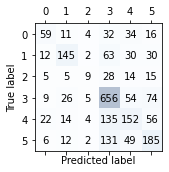

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()